<a href="https://colab.research.google.com/github/srliu/Colab/blob/main/15_SIP_BargainHunting(Colab%E7%89%88).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# 先下載台北黑體字型
# https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')
# 設定中文字型及負號正確顯示
plt.rcParams['font.sans-serif'] = 'Taipei Sans TC Beta'
plt.rcParams["axes.unicode_minus"] = False

--2023-03-03 22:26:27--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.163.138, 142.251.163.139, 142.251.163.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.163.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lsi0q0hgi2a5ik6rnn1klted3qq19i1k/1677882375000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=606e020a-7e05-4281-b576-5895ba5a82e3 [following]
--2023-03-03 22:26:31--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lsi0q0hgi2a5ik6rnn1klted3qq19i1k/1677882375000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=606e020a-7e05-4281-b576-5895ba5a82e3
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 142.251.163.132, 2607:f8b0:4004:c1b::84
Connecting to d

# Class Work

In [3]:
import datetime
Ticker=["00690.TW","00728.TW","0050.TW","2330.TW","2303.TW"] #股票List

In [4]:
start_download=int(datetime.datetime.strptime("2017033101","%Y%m%d%H").timestamp())
end_download=int(datetime.datetime.today().timestamp())

df_all=[]
for stock in Ticker:
    url=f"https://query1.finance.yahoo.com/v7/finance/download/{stock}?period1={start_download}&period2={end_download}&interval=1d&events=history&includeAdjustedClose=true"
    df_temp = pd.read_csv(url,usecols=["Date","Close"],index_col="Date",parse_dates=True)
    df_all.append(pd.DataFrame(df_temp['Close']))
df_all[0]

,Close
Date,
2017-03-31,19.910000
2017-04-05,19.950001
2017-04-06,19.930000
2017-04-07,19.840000
2017-04-10,19.799999
...,...
2023-02-23,27.440001
2023-02-24,27.260000
2023-03-01,27.330000


### 轉換股票代號為公司名稱
[爬取 Yahoo 股市即時股價解說網址](https://steam.oxxostudio.tw/category/python/spider/yahoo-stock.html)

In [5]:
stock_name=[]
import requests
from bs4 import BeautifulSoup

for i,stock in enumerate(Ticker):
  url = f'https://tw.stock.yahoo.com/quote/{Ticker[i][:-3]}'    # 台積電 Yahoo 股市網址
  web = requests.get(url)                 # 取得網頁內容
  soup = BeautifulSoup(web.text, "html.parser")    # 轉換內容
  title = soup.find('h2')             # 找到 h2 的內容
  stock_name.append(f'{title.get_text()[:-4]}')   # 放入xtitle list

stock_name  

['兆豐藍籌30', '第一金工業30', '元大台灣50', '台積電', '聯電']

In [6]:
PMT=3000
M=5
BH=-0.05
N=20

start='2018-4-10'
end='2022-8-31'

In [7]:
dfm_all=[]
for i in range(len(Ticker)):
    df=df_all[i].copy()
    dfm=df.resample('BM').last().loc[start:end].copy()
    dfm[f'{M}M-returns']=dfm.pct_change(M)
    dfm_all.append(dfm)

In [8]:
def caculate_dfm_BargainHunting(dfm):    
    total_cost_list=[]
    unit_list=[]
    pre_NAV_list=[0]
    TR_list=[0]

    for i, price in enumerate(dfm['Close']):
        if i==0:
            total_cost=PMT
            unit=PMT/price
            total_cost_list.append(total_cost)
            unit_list.append(unit)
        if i>0:
            if dfm[f'{M}M-returns'].iloc[i]<BH:
                total_cost+=N*PMT
                unit=unit+(N*PMT/price)
            else:
                total_cost+=PMT
                unit=unit+(PMT/price)
            pre_NAV=unit_list[i-1]*price
            TR=pre_NAV/total_cost_list[-1]-1
            total_cost_list.append(total_cost)
            unit_list.append(unit)
            pre_NAV_list.append(pre_NAV)
            TR_list.append(TR)

    dfm['total_cost']=total_cost_list
    dfm['unit']=unit_list
    dfm['pre_NAV']=pre_NAV_list
    dfm['total_return']=TR_list
    return dfm

In [9]:
for i in range(len(Ticker)):
    caculate_dfm_BargainHunting(dfm_all[i])

In [10]:
dfm_all[0]

,Close,5M-returns,total_cost,unit,pre_NAV,total_return
Date,,,,,,
2018-04-30,22.000000,NaN,3000,136.363636,0.000000,0.000000
2018-05-31,21.730000,NaN,6000,274.421621,2963.181818,-0.012273
2018-06-29,22.100000,NaN,9000,410.168227,6064.717818,0.010786
2018-07-31,22.910000,NaN,12000,541.115412,9396.954082,0.044106
2018-08-31,23.059999,NaN,15000,671.210821,12478.120852,0.039843
2018-09-28,22.799999,0.036364,18000,802.789774,15303.606039,0.020240
2018-10-31,20.389999,-0.061666,78000,3745.408849,16368.882684,-0.090618
2018-11-30,19.959999,-0.096833,138000,6751.421024,74758.356879,-0.041560
2018-12-31,19.400000,-0.153208,198000,9844.204529,130977.567857,-0.050887


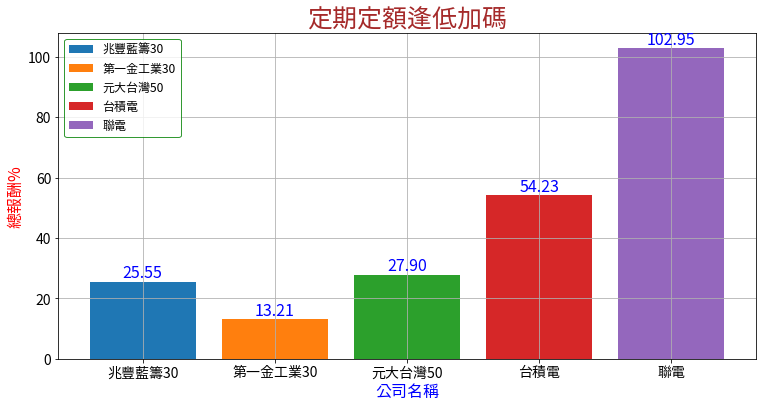

In [11]:
# plt.rcParams["figure.figsize"] = (12,6)    
plt.figure(figsize=(2.5*len(df_all),6))
plt.rcParams['font.size'] = '14'           # Set general font size
for i in range(len(dfm_all)):
    bar1=plt.bar(stock_name[i],dfm_all[i]['total_return'].iloc[-1]*100, align='center',label=f'{stock_name[i]}')
    plt.bar_label(bar1, fmt='%3.2f', label_type='edge',color='blue', fontsize=16)   #設定bar的值標示

plt.title('定期定額逢低加碼',color='brown', fontsize=25)
plt.ylabel('總報酬%', size=16, color='red')
plt.xlabel('公司名稱', fontsize=16, color='blue')

plt.legend(loc='upper left',edgecolor='green',  fontsize=12)
plt.grid()

In [12]:
BH=-100  #其實台股每日上下10%因此1個月營業日20天，最多也只能下跌200％(設BH=－2即可。)

In [13]:
dfm_all_SIP=[]      #統計不逢低加碼的報酬，以_SIP(下標)
for i in range(len(Ticker)):
    df_SIP=df_all[i].copy()
    dfm_SIP=df_SIP.resample('BM').last().loc[start:end].copy()
    dfm_SIP[f'{M}M-returns']=dfm_SIP.pct_change(M)  
    dfm_all_SIP.append(dfm_SIP)

In [14]:
dfm_all_SIP[0]

,Close,5M-returns
Date,,
2018-04-30,22.000000,NaN
2018-05-31,21.730000,NaN
2018-06-29,22.100000,NaN
2018-07-31,22.910000,NaN
2018-08-31,23.059999,NaN
2018-09-28,22.799999,0.036364
2018-10-31,20.389999,-0.061666
2018-11-30,19.959999,-0.096833
2018-12-31,19.400000,-0.153208


In [15]:
for i in range(len(Ticker)):
    caculate_dfm_BargainHunting(dfm_all_SIP[i])

In [16]:
dfm_all_SIP[0]

,Close,5M-returns,total_cost,unit,pre_NAV,total_return
Date,,,,,,
2018-04-30,22.000000,NaN,3000,136.363636,0.000000,0.000000
2018-05-31,21.730000,NaN,6000,274.421621,2963.181818,-0.012273
2018-06-29,22.100000,NaN,9000,410.168227,6064.717818,0.010786
2018-07-31,22.910000,NaN,12000,541.115412,9396.954082,0.044106
2018-08-31,23.059999,NaN,15000,671.210821,12478.120852,0.039843
2018-09-28,22.799999,0.036364,18000,802.789774,15303.606039,0.020240
2018-10-31,20.389999,-0.061666,21000,949.920728,16368.882684,-0.090618
2018-11-30,19.959999,-0.096833,24000,1100.221336,18960.416771,-0.097123
2018-12-31,19.400000,-0.153208,27000,1254.860512,21344.293923,-0.110654


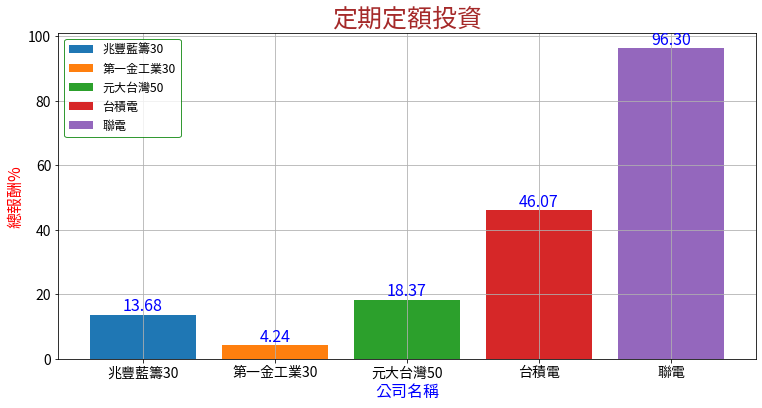

In [17]:
# plt.rcParams["figure.figsize"] = (12,6)    
plt.figure(figsize=(2.5*len(df_all),6))
plt.rcParams['font.size'] = '14'           # Set general font size
for i in range(len(dfm_all_SIP)):
    bar1=plt.bar(stock_name[i],dfm_all_SIP[i]['total_return'].iloc[-1]*100, align='center',label=f'{stock_name[i]}')
    plt.bar_label(bar1, fmt='%3.2f', label_type='edge',color='blue', fontsize=16)   #設定bar的值標示

plt.title('定期定額投資',color='brown', fontsize=25)
plt.ylabel('總報酬%', size=16, color='red')
plt.xlabel('公司名稱', fontsize=16, color='blue')

plt.legend(loc='upper left',edgecolor='green',  fontsize=12)
plt.grid()

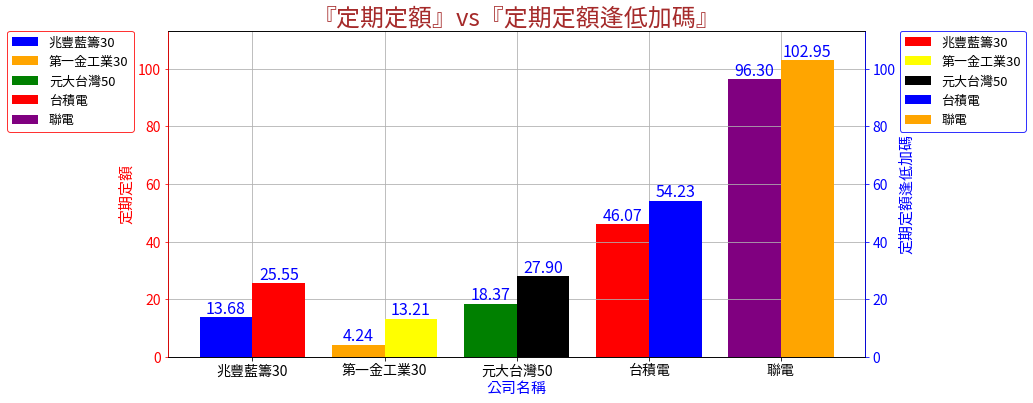

In [18]:
y_max = 0   #設定y軸最大值
fig, ax1 = plt.subplots(figsize=(2.5*len(df_all),6))
plt.title('『定期定額』vs『定期定額逢低加碼』', fontsize=24,color='brown')
plt.xlabel('公司名稱', fontsize=15,color='b')
color1 = ['blue','orange','green','red','purple','black','blue','orange','green','red','purple','black']
color2 = ['r','yellow','black','blue','orange','green','r','yellow','black','blue','orange','green']

ax2=ax1.twinx()

for i in range(len(dfm_all_SIP)):
    bar1=ax1.bar(stock_name[i],dfm_all_SIP[i]['total_return'].iloc[-1]*100,color=color1[i],
                 width=-0.4,align='edge',label=f'{stock_name[i]}')
    ax1.bar_label(bar1, fmt='%3.2f', label_type='edge',color='blue', fontsize=16)   #設定bar的值標示
    if (dfm_all_SIP[i]['total_return'].iloc[-1]*100) > y_max:
        y_max=dfm_all_SIP[i]['total_return'].iloc[-1]*100   #設定y軸最大值

ax1.set_ylabel('定期定額',color='red',fontsize=15)    
ax1.legend(stock_name,loc='upper right',bbox_to_anchor=(-0.04,1.02),edgecolor='r',fontsize=13)
ax1.grid()


for i in range(len(dfm_all)):
    bar2=ax2.bar(stock_name[i],dfm_all[i]['total_return'].iloc[-1]*100,color=color2[i],
                 width=0.4,align='edge',label=f'{stock_name[i]}')
    ax2.bar_label(bar2, fmt='%3.2f', label_type='edge',color='blue', fontsize=16)   #設定bar的值標示
    if (dfm_all[i]['total_return'].iloc[-1]*100) > y_max:
        y_max=dfm_all[i]['total_return'].iloc[-1]*100  #設定y軸最大值

ax2.set_ylabel('定期定額逢低加碼',color='blue',fontsize=15)
ax1.set_ylim(top=y_max*1.1)
ax2.set_ylim(top=y_max*1.1)
ax2.legend(stock_name,loc='upper left',bbox_to_anchor=(1.04,1.02),edgecolor='b',fontsize=13)

ax2.spines['right'].set_color('blue')
ax2.spines['left'].set_color('red')
ax1.tick_params(axis='y',colors='red')
ax2.tick_params(axis='y',colors="blue");

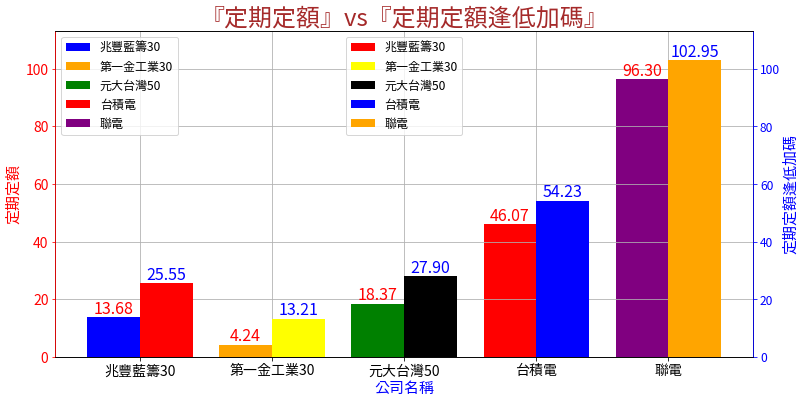

In [19]:
h1,h2=[],[]
for i in range(len(dfm_all)):
    h1.append(dfm_all_SIP[i]['total_return'].iloc[-1]*100)         # 第一組數據高度
    h2.append(dfm_all[i]['total_return'].iloc[-1]*100)        # 第二組數據高度
color1 = ['blue','orange','green','red','purple','black','blue','orange','green','red','purple','black']
color2 = ['r','yellow','black','blue','orange','green','r','yellow','black','blue','orange','green']
label=['5.0','7.5','10.0']


# 我們先製作出第一個subplot，然後把圖表的標題、X軸都設定好，再複製出第二個subplot
fig, ax1 = plt.subplots(figsize=(2.5*len(df_all),6))
# Set general font size
plt.rcParams['font.size'] = '12'
plt.title('『定期定額』vs『定期定額逢低加碼』', fontsize=24,color='brown')
plt.xlabel('公司名稱', fontsize=15,color='b')
ax2 = ax1.twinx()

# 現在來設定第一個subplot，給定顏色、Y軸等等的
bar1=ax1.bar(stock_name,h1,color=color1,tick_label=stock_name,width=-0.4, align='edge',label=stock_name)  # 第一組數據靠左邊緣對齊
ax1.bar_label(bar1, fmt='%3.2f', label_type='edge', fontsize=16,color='red')   #設定bar的值標示
ax1.set_ylim(top=max(h1+h2)*1.1)
ax1.set_ylabel('定期定額',color='r',fontsize=15)
ax1.legend()
ax1.grid()

# 換第二個subplot
bar2=ax2.bar(stock_name,h2,color=color2,tick_label=stock_name,width=0.4, align='edge',label=stock_name)  # 第二組數據置中對齊
ax2.bar_label(bar2, fmt='%3.2f', label_type='edge', fontsize=16,color='blue')   #設定bar的值標示
ax2.set_ylim(top=max(h1+h2)*1.1)
ax2.set_ylabel('定期定額逢低加碼',color='b',fontsize=15)
ax2.legend(loc='upper center')

ax2.spines['right'].set_color('blue')
ax2.spines['left'].set_color('red')
ax1.tick_params(axis='y',colors='red')
ax2.tick_params(axis='y',colors="blue");